# Ak Bars Online (mobile) churn rate prediction

### Источник данных

Для составления исходного dataFrame (df_main) используются сессионные данные, доступные в приложении AppMetrica, а также данные о платежах и переводах, отправляемых разработчиками в AppMetrica.

Количество пользователей считается по уникальному идентификатору устройства, который присваивается AppMetrica (параметр DeviceID).

### Импорт библиотек + вспомогательные функции для работы с данными Clickhouse

In [1]:
HOST = 'http://localhost:8123'
import requests
import pandas as pd
import numpy as np
import seaborn as sns
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

# убираем scientific notation
pd.options.display.float_format = '{:.2f}'.format

# отключим предупреждения
import warnings
warnings.filterwarnings('ignore')

import itertools
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

# возвращаем результат из DataBase
def get_clickhouse_data(query, host = HOST, connection_timeout = 1500):
    r = requests.post(host, params = {'query': query}, timeout = connection_timeout)
    if r.status_code == 200:
        return r.text
    else:
        raise ValueError(r.text)
        
# преобразуем полученные данные в pandas DataFrame       
def get_clickhouse_df(query, host = HOST, connection_timeout = 1500):
    data = get_clickhouse_data(query, host, connection_timeout) 
    df = pd.read_csv(StringIO(data), sep = '\t')
    return df

# константы для работы с временными диапазонами

# вчерашняя дата
yesterday = [(datetime.date.today() - datetime.timedelta(days=2)).strftime('%Y-%m-%d'),
            (datetime.date.today() - datetime.timedelta(days=2)).strftime('%Y-%m-%d')]
# последние 7 дней (без учета текущей даты)
week_dates = [(datetime.date.today() - datetime.timedelta(days=7)).strftime('%Y-%m-%d'), \
(datetime.date.today() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')]
# текущий месяц (без учета текущей даты)
month_dates = [datetime.date.today().strftime('%Y-%m-') + '01', \
(datetime.date.today() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')]

# выставляем даты для отчета
# query_dates = ['2018-06-01', '2018-07-31'];
query_dates = ['2018-09-03', '2018-10-03'];

# выставляем даты для целевого признака по оттоку
churn_query_dates = ['2018-08-01', '2018-08-31'];

# формат даты
fmt = '%Y-%m-%d'

# функция для расчета признаков, связанных с сессиями пользователей (например, avgdaylag (средний кол-во дней между сессиями))
def func(a):
    i1, i2 = itertools.tee(iter(a))
    next(i2)
    res = [(int(round((datetime.strptime(y, fmt) - datetime.strptime(x, fmt)).total_seconds() / 60))) / 1440
    for x, y in zip(i1, i2)]  # or just zip in Python 3
    return round(np.mean(res),2)

from datetime import datetime

# здесь выставляем первое число месяца, на который прогнозируем отток

reportDate = datetime(2018, 9, 1)

sns.set(rc={'axes.facecolor':'grey', 'figure.facecolor':'grey'})
sns.set(palette='Blues_r')

## ВСЕ СЕССИИ

Получим данные по сессиям за период. В нашем случае за четыре месяца (май-август 2018)

In [2]:
%%time

q = '''
SELECT
    DeviceID,
    AppVersionName,
    OSName,
    SessionStartDate,
    SessionStartDateTime,
    SessionStartTimestamp
FROM
    mobile.sessions_starts_all
WHERE
    SessionStartDate BETWEEN ''' + ''' \'''' + \
    query_dates[0] + '''\' AND ''' + '''\'''' + \
    query_dates[1] + '''\' ''''FORMAT TabSeparatedWithNames'''

sessions = get_clickhouse_df(q)

CPU times: user 7.43 s, sys: 2.57 s, total: 10 s
Wall time: 11.7 s


Либо подгрузим ранее экспортированные данные из AppMetrica

Пример запроса для получения данных по сессиям

https://appmetrica.yandex.ru/export-log?url=%2Flogs-exporter%2Fsessions_starts%2Fcsv%2F%3Fapplication_id%3D773292%26date_since%3D2018-05-01%252000%253A00%253A00%26date_until%3D2018-09-30%252023%253A59%253A59%26date_dimension%3Ddefault%26use_utf8_bom%3Dtrue%26fields%3Dappmetrica_device_id%252Capp_version_name%252Csession_start_datetime%252Csession_start_timestamp%26inteface%3D1

In [3]:
sessions.head()

,DeviceID,AppVersionName,OSName,SessionStartDate,SessionStartDateTime,SessionStartTimestamp
0,10505484930268923928,3.20.0,ios,2018-09-03,2018-09-03 22:30:40,1536013840
1,14946039178146968182,3.24.1,android,2018-09-03,2018-09-03 21:05:31,1536008731
2,3166121082083361625,3.24.1,android,2018-09-03,2018-09-03 23:16:30,1536016590
3,7126554865110011613,3.24.1,android,2018-09-03,2018-09-03 21:17:46,1536009466
4,17090988081681948002,3.20.0,ios,2018-09-03,2018-09-03 22:18:47,1536013127


Создадим общий dataframe для пользователей, куда будем добавлять агрегированные данные. Посчитаем кол-во сессий на DeviceID, используя SessionStartTimestamp в качестве ID сессии

In [8]:
%%time

df_main = sessions.groupby('DeviceID')[['SessionStartTimestamp']]\
    .count().reset_index().sort_values(by='SessionStartTimestamp', ascending=False)

CPU times: user 588 ms, sys: 174 ms, total: 762 ms
Wall time: 769 ms


Запишем дни сессий в порядке возрастания массивом в колонку SessionStartDate

In [9]:
df_main['SessionStartDate'] = [sorted(list(set(sessions['SessionStartDate'].loc[sessions['DeviceID'] == x['DeviceID']])))  
    for _, x in df_main.iterrows()]

Посчитаем среднюю продолжительность перерыва между днями, в течение которых были сессии

In [10]:
df_main['sessions_avgdaylag'] = df_main.apply(lambda x: func(x['SessionStartDate']), axis=1)

Если у пользователя был один активный день, то avgdaylag будет равен кол-ву дней с этого дня и до даты отчета

In [11]:
tempSer = df_main[df_main['sessions_avgdaylag'].isnull()]['SessionStartDate'].apply(
     lambda x: round((int(round((reportDate - datetime.strptime(x[0], fmt)).total_seconds() / 60))) / 1440))

In [12]:
df_main['sessions_avgdaylag'] = df_main['sessions_avgdaylag'].fillna(tempSer)

Посчитаем кол-во дней, прошешдишх с последней сессии пользователя от даты формирования отчета

In [13]:
temp = sessions.groupby('DeviceID')[['SessionStartDate']].max().reset_index()
temp['sessions_daysSinceLastSession'] = temp['SessionStartDate'].apply(
    lambda x: round((int(round((reportDate - datetime.strptime(x, fmt)).total_seconds() / 60))) / 1440))
df_main = df_main.join(temp.drop(['SessionStartDate'], axis=1).set_index('DeviceID'), on='DeviceID')

Посчитаем количество дней, когда пользователь был активен в приложении

In [14]:
df_main['sessions_totaldaysactive'] = df_main['SessionStartDate'].apply(lambda x: len(x))

Удалим массив уникальных дат с сессиями и переименуем столбец SessionStartTimestamp

In [15]:
df_main = df_main.drop(['SessionStartDate'], axis=1).rename(index=str, columns={
    "SessionStartTimestamp": "sessions_totalnumber"
})

## ВСЕ СОБЫТИЯ

Создадим временный dataframe для всех событий

In [16]:
q = '''
SELECT
    AppVersionName,
    OSName,
    EventDate,
    ReceiveDate,
    ReceiveTimestamp,
    EventTimestamp,
    EventDateTime,
    EventName,
    DeviceID,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'crmId') AS VARCHAR) AS crmId,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'status') AS VARCHAR) AS authStatus,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'gender') AS VARCHAR) AS gender,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'тип операции') AS VARCHAR) AS operationType,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'сумма операции') AS VARCHAR) AS operationAmount,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'источник') AS VARCHAR) AS sender,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'валюта отправителя') AS VARCHAR) AS senderCurrency,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'получатель') AS VARCHAR) AS recipient,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'валюта получателя') AS VARCHAR) AS recipientCurrency,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'размер комиссии') AS VARCHAR) AS operationFee,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'способ операции') AS VARCHAR) AS operationMethod,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'срок') AS VARCHAR) AS depositTerm,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'валюта') AS VARCHAR) AS depositCurrency,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'ставка') AS VARCHAR) AS depositRate,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'название') AS VARCHAR) AS depositName,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'тип чата') AS VARCHAR) AS chatType,
    CAST(visitParamExtractRaw(replaceAll(EventParameters, '""', '"'), 'операция') AS VARCHAR) AS operation
FROM
    mobile.events_all
WHERE
    match(EventName,'продажи|переводы|Переводы|^платежи$')
    AND EventDate BETWEEN ''' + ''' \'''' + \
    query_dates[0] + '''\' AND ''' + '''\'''' + \
    query_dates[1] + '''\' ''''FORMAT TabSeparatedWithNames'''

events = get_clickhouse_df(q)

## ПЛАТЕЖИ

Создадим отдельный dataframe для платежей без добавления платежи, где сумма операция неизвестна (недоступна)

In [17]:
payments = pd.read_csv('../dmitriilin/Downloads/AppMetrica Data (may-september 2018)/payments_may_september2018.csv',
                       sep=',')

In [18]:
payments.drop(['Unnamed: 0'],
              axis=1,
              inplace=True)

Рассчитаем агрегаты для платежей

In [19]:
f = {
    'operationAmount':['count','sum', 'median', 'min', 'max'], #количество, сумма, медиана, минимум и максимум
    'sender': ['nunique'], #кол-во уникальных источников платежей
    'recipient': ['nunique'], #кол-во получателей платежей
    'operationMethod': ['nunique'] #кол-во способов платежей
}

# расчитаем агрегаты по каждому DeviceID

payments_agg = payments.groupby(['DeviceID']).agg(f)
payments_agg.columns = payments_agg.columns.map('_'.join)
payments_agg = payments_agg.reset_index().rename(columns={
    'operationAmount_count': 'payments_operationAmount_count',
    'operationAmount_sum': 'payments_operationAmount_sum',
    'operationAmount_median': 'payments_operationAmount_median',
    'operationAmount_min': 'payments_operationAmount_min',
    'operationAmount_max': 'payments_operationAmount_max',
    'sender_nunique': 'payments_sender_nunique',
    'recipient_nunique': 'payments_recipient_nunique',
    'operationMethod_nunique': 'payments_operationMethod_nunique'
})

Запишем дни платежей в порядке возрастания массивом в колонку payments_date

In [20]:
payments_agg['payments_date'] = [sorted(list(set(payments['EventDate'].loc[payments['DeviceID'] == x['DeviceID']])))  
    for _, x in payments_agg.iterrows()]

Посчитаем среднюю продолжительность перерыва между днями, в течение которых были платежи.
Посчитаем количество дней, когда пользователь совершал платежи в приложении.

In [21]:
payments_agg['payments_avgdaylag'] = payments_agg.apply(lambda x: func(x['payments_date']), axis=1)
payments_agg['payments_daysactive'] = payments_agg['payments_date'].apply(lambda x: len(x))

payments_agg = payments_agg.drop(['payments_date'], axis=1)

Запишем данные о платежах в основой dataFrame

In [22]:
df_main = df_main.join(payments_agg.set_index('DeviceID'), on='DeviceID')

Посчитаем кол-во дней, прошешдишх с последнего платежаа пользователя от даты формирования отчета

In [23]:
temp = payments.groupby('DeviceID')[['EventDate']].max().reset_index()
temp['payments_daysSinceLastPayment'] = temp['EventDate'].apply(
    lambda x: round((int(round((reportDate - datetime.strptime(x, fmt)).total_seconds() / 60))) / 1440))
df_main = df_main.join(temp.drop(['EventDate'], axis=1).set_index('DeviceID'), on='DeviceID')

Заполним отсутствующие данные для тех, кто ни разу не совершал платеж в выбранный период. Для признаков avgdaylag & daysSinceLastPayemnt запишем 122 дней (общее количество дней в периоде).

In [24]:
fillna0 = [
    'payments_operationAmount_count',
    'payments_operationAmount_sum',
    'payments_operationAmount_median',
    'payments_operationAmount_min',
    'payments_operationAmount_max',
    'payments_sender_nunique',
    'payments_recipient_nunique',
    'payments_operationMethod_nunique',
    'payments_daysactive'
]

fillna122 = ['payments_avgdaylag', 'payments_daysSinceLastPayment']

for i in fillna0:
    df_main[i].fillna(0, inplace=True)

for i in fillna122:
    df_main[i].fillna(122, inplace=True)

## ПЕРЕВОДЫ

Для переводов посчитаем те же агрегаты, что и для платежей

In [25]:
fundTransfers = pd.read_csv('../dmitriilin/Downloads/AppMetrica Data (may-september 2018) 2/transfers_may_september2018.csv',
                       sep=',')

In [26]:
f = {
    'operationAmount':['count','sum', 'median', 'min', 'max'], #количество и сумма операций
    'operationFee': ['sum'], #сумма комиссий
    'sender': ['nunique'], #кол-во источников перевода
    'recipient': ['nunique'], #кол-во получателей перевода
    'operationMethod': ['nunique'], #кол-во способов перевода
    'senderCurrency': ['nunique'], #кол-во валют источника перевода
    'recipientCurrency': ['nunique'] #кол-во валют получателя перевода
}

fundTransfers_agg = fundTransfers.groupby(['DeviceID']).agg(f)
fundTransfers_agg.columns = fundTransfers_agg.columns.map('_'.join)
fundTransfers_agg = fundTransfers_agg.reset_index().rename(columns={
    'operationAmount_count': 'transfers_operationAmount_count',
    'operationAmount_sum': 'transfers_operationAmount_sum',
    'operationAmount_median': 'transfers_operationAmount_median',
    'operationAmount_min': 'transfers_operationAmount_min',
    'operationAmount_max': 'transfers_operationAmount_max',
    'operationFee_sum': 'transfers_operationFee_sum',
    'sender_nunique': 'transfers_sender_nunique',
    'recipient_nunique': 'transfers_recipient_nunique',
    'operationMethod_nunique': 'transfers_operationMethod_nunique',
    'senderCurrency_nunique': 'transfers_senderCurrency_nunique',
    'recipientCurrency_nunique': 'transfers_recipientCurrency_nunique'
})

In [27]:
fundTransfers_agg['transfers_date'] = [sorted(list(set(fundTransfers['EventDate'].loc[fundTransfers['DeviceID'] == x['DeviceID']])))  
    for _, x in fundTransfers_agg.iterrows()]

fundTransfers_agg['transfers_avgdaylag'] = fundTransfers_agg.apply(lambda x: func(x['transfers_date']), axis=1)
fundTransfers_agg['transfers_daysactive'] = fundTransfers_agg['transfers_date'].apply(lambda x: len(x))

fundTransfers_agg = fundTransfers_agg.drop(['transfers_date'], axis=1)

In [28]:
df_main = df_main.join(fundTransfers_agg.set_index('DeviceID'), on='DeviceID')

In [29]:
temp = fundTransfers.groupby('DeviceID')[['EventDate']].max().reset_index()
temp['transfers_daysSinceLastTransfer'] = temp['EventDate'].apply(
    lambda x: round((int(round((reportDate - datetime.strptime(x, fmt)).total_seconds() / 60))) / 1440))
df_main = df_main.join(temp.drop(['EventDate'], axis=1).set_index('DeviceID'), on='DeviceID')

In [30]:
fillna0 = [
    'transfers_operationAmount_count',
    'transfers_operationAmount_sum',
    'transfers_operationAmount_median',
    'transfers_operationAmount_min',
    'transfers_operationAmount_max',
    'transfers_operationFee_sum',
    'transfers_sender_nunique',
    'transfers_recipient_nunique',
    'transfers_operationMethod_nunique',
    'transfers_senderCurrency_nunique',
    'transfers_recipientCurrency_nunique',
]

fillna122 = ['transfers_avgdaylag', 'transfers_daysactive', 'transfers_daysSinceLastTransfer']

for i in fillna0:
    df_main[i].fillna(0, inplace=True)

for i in fillna122:
    df_main[i].fillna(122, inplace=True)

## СЧИТАЕМ CHURN И ПРОСТАВЛЯЕМ TARGET FEATURE

In [31]:
q = '''
SELECT
    DeviceID,
    AppVersionName,
    OSName,
    ReceiveDate,
    ReceiveTimestamp,
    SessionStartDate,
    SessionStartDateTime,
    SessionStartTimestamp
FROM
    mobile.sessions_starts_all
WHERE
    SessionStartDate BETWEEN ''' + ''' \'''' + \
    churn_query_dates[0] + '''\' AND ''' + '''\'''' + \
    churn_query_dates[1] + '''\' ''''FORMAT TabSeparatedWithNames'''

sessions = get_clickhouse_df(q)

In [32]:
sessions = pd.read_csv('../dmitriilin/Downloads/sessions_starts.csv', sep=',')

In [33]:
# посчитаем кол-во сессий на DeviceID, используя SessionStartTimestamp в качестве ID сессии

df_sessions_churn = sessions.groupby('appmetrica_device_id')[['session_start_timestamp']]\
    .count().reset_index().sort_values(by='session_start_timestamp', ascending=False)

Посмотрим, какие DeviceID, из тех, что присутствуют в общем dataFrame за период, вернулись в прогнозируем периоде. Если DeviceID найден, ставим "0" (неотток), в противном случае - "1" (отток)

In [34]:
df_main.columns

Index(['DeviceID', 'sessions_totalnumber', 'sessions_avgdaylag',
       'sessions_daysSinceLastSession', 'sessions_totaldaysactive',
       'payments_operationAmount_count', 'payments_operationAmount_sum',
       'payments_operationAmount_median', 'payments_operationAmount_min',
       'payments_operationAmount_max', 'payments_sender_nunique',
       'payments_recipient_nunique', 'payments_operationMethod_nunique',
       'payments_avgdaylag', 'payments_daysactive',
       'payments_daysSinceLastPayment', 'transfers_operationAmount_count',
       'transfers_operationAmount_sum', 'transfers_operationAmount_median',
       'transfers_operationAmount_min', 'transfers_operationAmount_max',
       'transfers_operationFee_sum', 'transfers_sender_nunique',
       'transfers_recipient_nunique', 'transfers_operationMethod_nunique',
       'transfers_senderCurrency_nunique',
       'transfers_recipientCurrency_nunique', 'transfers_avgdaylag',
       'transfers_daysactive', 'transfers_daysSinceLa

In [35]:
df_main['churned'] = df_main['DeviceID'].isin(df_sessions_churn['appmetrica_device_id']).apply(lambda x: 0 if x is True else 1)

Как видим, 4-месячный отток составляет порядка 35% процентов.

In [36]:
df_main['churned'].value_counts(normalize=True)

0   0.66
1   0.34
Name: churned, dtype: float64

Посмотрим, как признаки из разных категория коррелируют с целевым

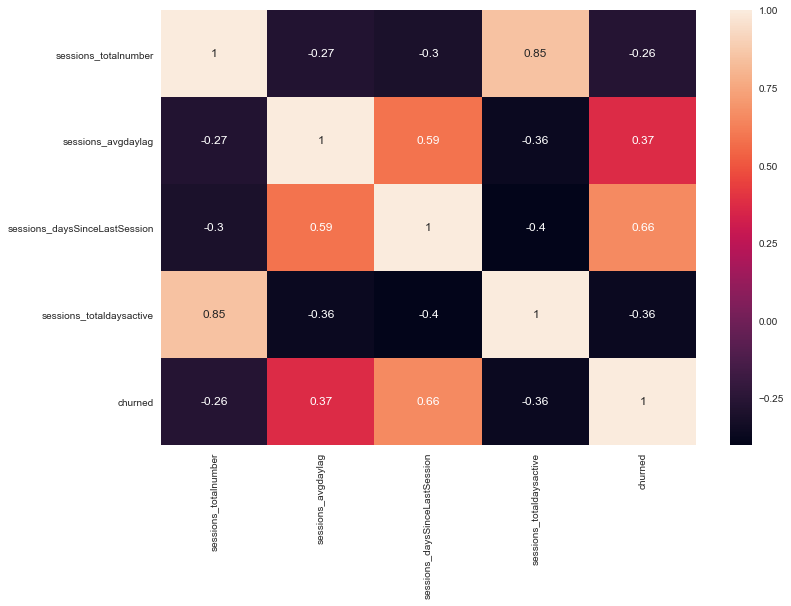

In [37]:
sns.heatmap(df_main[[f for f in df_main.columns if 'sessions' in f or 'churned' in f]].corr(), annot=True);
# sns.heatmap(df_main[[f for f in df_main.columns if 'payments' in f or 'churned' in f]].corr(), annot=True);
# sns.heatmap(df_main[[f for f in df_main.columns if 'transfers' in f or 'churned' in f]].corr(), annot=True);

Наконец, посмотрим на получившийся dataFrame

In [38]:
df_main.tail()

,DeviceID,sessions_totalnumber,sessions_avgdaylag,sessions_daysSinceLastSession,sessions_totaldaysactive,payments_operationAmount_count,payments_operationAmount_sum,payments_operationAmount_median,payments_operationAmount_min,payments_operationAmount_max,...,transfers_operationFee_sum,transfers_sender_nunique,transfers_recipient_nunique,transfers_operationMethod_nunique,transfers_senderCurrency_nunique,transfers_recipientCurrency_nunique,transfers_avgdaylag,transfers_daysactive,transfers_daysSinceLastTransfer,churned
134993,11652750677926616943,1,64.00,64,1,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,122.00,122.00,122.00,1
134991,11652467921430136755,1,7.00,7,1,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,122.00,122.00,122.00,1
201752,17423490244212443576,1,90.00,90,1,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,122.00,122.00,122.00,1
134990,11652302996568120843,1,6.00,6,1,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,122.00,122.00,122.00,1
25842,2228942890004763754,1,61.00,61,1,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,122.00,122.00,122.00,1


In [39]:
df_main.columns

Index(['DeviceID', 'sessions_totalnumber', 'sessions_avgdaylag',
       'sessions_daysSinceLastSession', 'sessions_totaldaysactive',
       'payments_operationAmount_count', 'payments_operationAmount_sum',
       'payments_operationAmount_median', 'payments_operationAmount_min',
       'payments_operationAmount_max', 'payments_sender_nunique',
       'payments_recipient_nunique', 'payments_operationMethod_nunique',
       'payments_avgdaylag', 'payments_daysactive',
       'payments_daysSinceLastPayment', 'transfers_operationAmount_count',
       'transfers_operationAmount_sum', 'transfers_operationAmount_median',
       'transfers_operationAmount_min', 'transfers_operationAmount_max',
       'transfers_operationFee_sum', 'transfers_sender_nunique',
       'transfers_recipient_nunique', 'transfers_operationMethod_nunique',
       'transfers_senderCurrency_nunique',
       'transfers_recipientCurrency_nunique', 'transfers_avgdaylag',
       'transfers_daysactive', 'transfers_daysSinceLa

In [40]:
df_main.shape

(213702, 31)

In [41]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213702 entries, 140125 to 25842
Data columns (total 31 columns):
DeviceID                               213702 non-null uint64
sessions_totalnumber                   213702 non-null int64
sessions_avgdaylag                     213702 non-null float64
sessions_daysSinceLastSession          213702 non-null int64
sessions_totaldaysactive               213702 non-null int64
payments_operationAmount_count         213702 non-null float64
payments_operationAmount_sum           213702 non-null float64
payments_operationAmount_median        213702 non-null float64
payments_operationAmount_min           213702 non-null float64
payments_operationAmount_max           213702 non-null float64
payments_sender_nunique                213702 non-null float64
payments_recipient_nunique             213702 non-null float64
payments_operationMethod_nunique       213702 non-null float64
payments_avgdaylag                     213702 non-null float64
payments_daysac

__________________

## Exploratory data analysis

In [5]:
#delete this cell

df_main = pd.read_csv('../dmitriilin/Desktop/data frames for ML/df_main_may_august2018.csv')

In [6]:
example = df_main[[f for f in df_main.columns if 'sessions' in f or 'churned' in f]][

    ((df_main['sessions_daysSinceLastSession'] > df_main['sessions_daysSinceLastSession'].quantile(.1)) &
    (df_main['sessions_daysSinceLastSession'] < df_main['sessions_daysSinceLastSession'].quantile(.75)))
    &
    ((df_main['sessions_avgdaylag'] > df_main['sessions_avgdaylag'].quantile(.1)) &
    (df_main['sessions_avgdaylag'] < df_main['sessions_avgdaylag'].quantile(.75)))
    &
    ((df_main['sessions_totaldaysactive'] > df_main['sessions_totaldaysactive'].quantile(.10)) &
    (df_main['sessions_totaldaysactive'] < df_main['sessions_totaldaysactive'].quantile(.75)))
    &
    ((df_main['sessions_totalnumber'] > df_main['sessions_totalnumber'].quantile(.10)) &
    (df_main['sessions_totalnumber'] < df_main['sessions_totalnumber'].quantile(.75)))
]

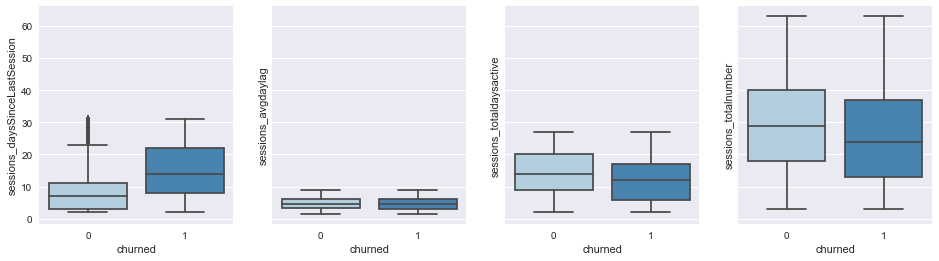

In [7]:
_, axes = plt.subplots(1, 4, sharey=True, figsize=(16,4))

sns.boxplot(y='sessions_daysSinceLastSession', x='churned', data=example, palette='Blues', ax=axes[0]);
sns.boxplot(y='sessions_avgdaylag', x='churned', data=example, palette='Blues', ax=axes[1]);
sns.boxplot(y='sessions_totaldaysactive', x='churned', data=example, palette='Blues', ax=axes[2]);
sns.boxplot(y='sessions_totalnumber', x='churned', data=example, palette='Blues', ax=axes[3]);

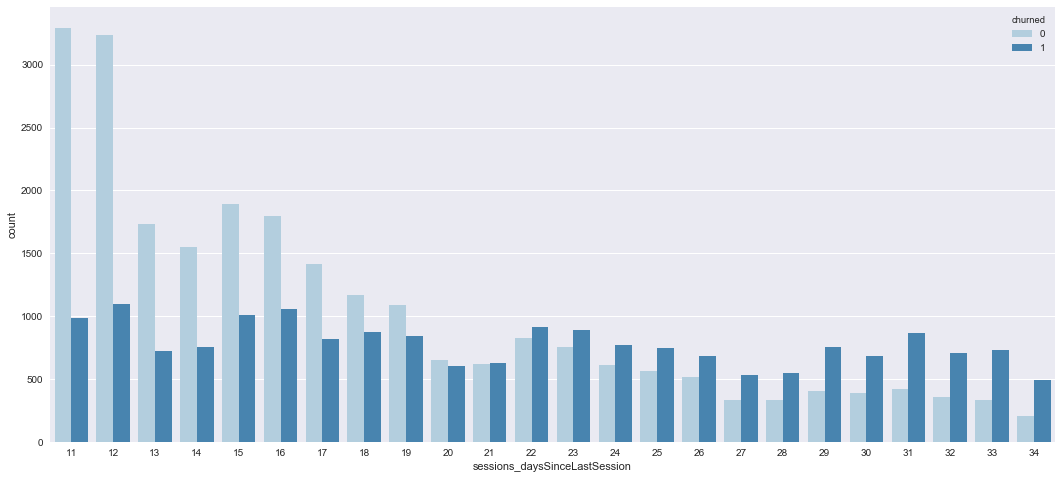

In [8]:
sns.set(rc={"figure.figsize": (18, 8)})
sns.countplot(
    x='sessions_daysSinceLastSession',
    hue='churned',
    data=df_main[(df_main['sessions_daysSinceLastSession'] > 10) &
                 (df_main['sessions_daysSinceLastSession'] < 35)],
    palette='Blues'
);

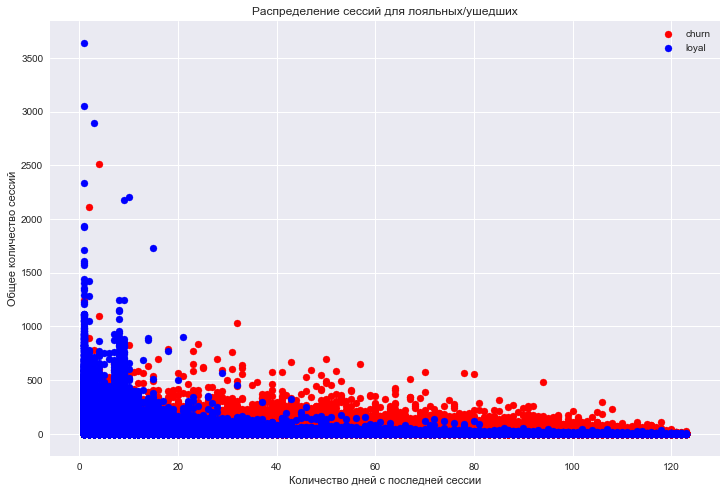

In [103]:
plt.scatter(df_main[df_main['churned'] == 1]['sessions_daysSinceLastSession'], 
            df_main[df_main['churned'] == 1]['sessions_totalnumber'],
           color='red', label='churn');
plt.scatter(df_main[df_main['churned'] == 0]['sessions_daysSinceLastSession'], 
            df_main[df_main['churned'] == 0]['sessions_totalnumber'],
           color='blue', label='loyal');
plt.xlabel('Количество дней с последней сессии');
plt.ylabel('Общее количество сессий');
plt.title('Распределение сессий для лояльных/ушедших');
plt.legend();

__________________

## FEATURE ENGINEERING

Добавим несколько новых признаков, основывающихся, прежде всего, на сессионых данных пользователей.

In [42]:
# общее количество сессий за 4 месяца меньше 2

df_main['sessions_totalnumber_less_2'] = df_main['sessions_totalnumber'].apply(lambda x: 1 if x < 2 else 0)

In [43]:
# общее количество сессий за 4 месяца меньше 6

df_main['sessions_totalnumber_less_6'] = df_main['sessions_totalnumber'].apply(lambda x: 1 if x < 6 else 0)

In [44]:
# общее количество активных дней за 4 месяца меньше 2

df_main['sessions_totaldaysactive_less_2'] = df_main['sessions_totaldaysactive'].apply(lambda x: 1 if x < 2 else 0)

In [45]:
df_main['sessions_avgdaylag_greater_20'] = df_main['sessions_avgdaylag'].apply(lambda x: 1 if x > 20.5 else 0)
df_main['sessions_avgdaylag_greater_10'] = df_main['sessions_avgdaylag'].apply(lambda x: 1 if x > 10 else 0)
df_main['sessions_avgdaylag_greater_15'] = df_main['sessions_avgdaylag'].apply(lambda x: 1 if x > 15 else 0)
df_main['sessions_totaldaysactive_equalsless_2'] = df_main['sessions_totaldaysactive'].apply(lambda x: 1 if x <= 2 else 0)
df_main['sessions_daysSinceLastSession_equalsgreater_19'] = df_main['sessions_daysSinceLastSession'].apply(lambda x: 1 if x >= 19 else 0)
df_main['sessions_totalnumber_equalsless_5'] = df_main['sessions_totalnumber'].apply(lambda x: 1 if x <= 5 else 0)

In [46]:
def label_race(row):
    if (row['sessions_avgdaylag_greater_10'] == 1 and row['sessions_totaldaysactive_equalsless_2'] == 1 and
        row['sessions_daysSinceLastSession_equalsgreater_19'] == 1 and row['sessions_totalnumber_equalsless_5'] == 1):
        return 1
    else:
        return 0

In [47]:
df_main['sessions_isPassive'] = df_main.apply(lambda row: label_race (row),axis=1)

In [48]:
df_main['payments_isPassive'] = df_main['payments_operationAmount_count'].apply(lambda x: 1 if x == 0 else 0)
df_main['transfers_isPassive'] = df_main['transfers_operationAmount_count'].apply(lambda x: 1 if x == 0 else 0)

Построим кор. матрицу для "сессионных" признаков

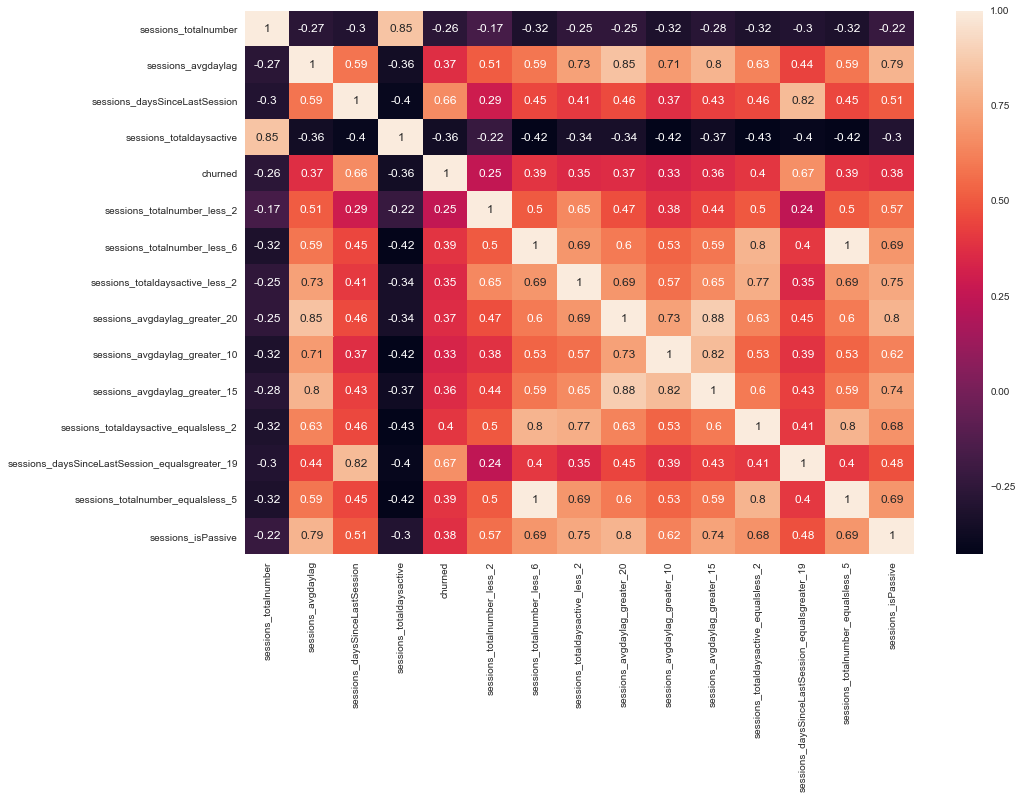

In [49]:
fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(df_main[[f for f in df_main.columns if 'sessions' in f or 'churned' in f]].corr(), annot=True);

_______

In [96]:
df_main.to_csv('../dmitriilin/Desktop/df_main_may_august2018.csv')

In [107]:
df_main[df_main['churned'] == 1]['sessions_totalnumber'].median(),\
df_main[df_main['churned'] == 0]['sessions_totalnumber'].median()

(8.0, 40.0)

In [106]:
df_main[df_main['churned'] == 1]['sessions_totaldaysactive'].median(),\
df_main[df_main['churned'] == 0]['sessions_totaldaysactive'].median()

(4.0, 19.0)

In [113]:
df_main[df_main['churned'] == 1]['sessions_avgdaylag'].median(),\
df_main[df_main['churned'] == 0]['sessions_avgdaylag'].median()

(6.86, 3.41)

In [121]:
df_main[df_main['churned'] == 1]['payments_operationAmount_count'].mean(),\
df_main[df_main['churned'] == 0]['payments_operationAmount_count'].mean()

(1.6443201963725624, 7.847448209044539)

In [122]:
df_main[df_main['churned'] == 1]['transfers_operationAmount_count'].mean(),\
df_main[df_main['churned'] == 0]['transfers_operationAmount_count'].mean()

(1.6706668484931133, 8.165360613227708)

## ОБУЧАЕМ МОДЕЛЬ (-И)

In [57]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.metrics import f1_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter

In [58]:
y = df_main['churned']
X = df_main.drop(['churned'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.3, random_state=42)

__________________

## RANDOM FOREST

In [62]:
print(classification_report(y_valid, forest.predict(X_valid), target_names=['non-churned', 'churned']))

             precision    recall  f1-score   support

non-churned       0.90      0.92      0.91     41993
    churned       0.84      0.81      0.82     22118

avg / total       0.88      0.88      0.88     64111



## GradientBoosting (LIGHT)

In [65]:
import lightgbm as lgb

# Set params
# Scores ~0.784 (without tuning and early stopping)
params = {
    'boosting_type': 'gbdt',
    'max_depth' : -1,
    'objective': 'binary',
    'nthread': 3, # Updated from nthread
    'num_leaves': 34,
    'learning_rate': 0.1,
    'max_bin': 1024,
    'subsample_for_bin': 200,
    'subsample': 1,
    'subsample_freq': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 5,
    'reg_lambda': 10,
    'min_split_gain': 0.5,
    'min_child_weight': 1,
    'min_child_samples': 5,
    'scale_pos_weight': 1,
    'num_class' : 1,
    'metric' : 'binary_logloss',
    'num_iterations' : 200
}

gridParams = {
    'learning_rate': [0.1],
    'n_estimators': [40],
    'num_leaves': [31],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [42], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1.2, 1.4],
    'reg_lambda' : [1.2, 1.4]
}

lgbm = lgb.LGBMClassifier(
    boosting_type= params['boosting_type'],
    objective = params['objective'],
    n_jobs = -1, # Updated from 'nthread'
    silent = True,
    max_depth = params['max_depth'],
    max_bin = params['max_bin'],
    subsample_for_bin = params['subsample_for_bin'],
    subsample = params['subsample'],
    subsample_freq = params['subsample_freq'],
    min_split_gain = params['min_split_gain'],
    min_child_weight = params['min_child_weight'],
    min_child_samples = params['min_child_samples'],
    scale_pos_weight = params['scale_pos_weight'],
    learning_rate = params['learning_rate'],
    num_iterations=params['num_iterations'],
    num_leaves=params['num_leaves']
)

In [66]:
lgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_bin=1024, max_depth=-1, min_child_samples=5,
        min_child_weight=1, min_split_gain=0.5, n_estimators=100,
        n_jobs=-1, num_iterations=200, num_leaves=34, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=1, silent=True, subsample=1,
        subsample_for_bin=200, subsample_freq=1)

In [67]:
# F1 score для litegb - параметры НЕоптимизированы

report = classification_report(y_valid, lgbm.predict(X_valid), target_names=['Non-churned', 'Churned'])
print(report)

             precision    recall  f1-score   support

Non-churned       0.92      0.91      0.91     41993
    Churned       0.83      0.85      0.84     22118

avg / total       0.89      0.89      0.89     64111



/Users/dmitriilin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [71]:
%%time
lgbm_grid = GridSearchCV(lgbm, gridParams,
                    verbose=False,
                    cv=5,
                    n_jobs=-1, scoring='f1')
lgbm_grid.fit(X_train, y_train)

CPU times: user 18.2 s, sys: 452 ms, total: 18.7 s
Wall time: 8min 1s


In [72]:
lgbm_grid.best_params_, lgbm_grid.best_score_

({'boosting_type': 'gbdt',
  'colsample_bytree': 0.66,
  'learning_rate': 0.1,
  'n_estimators': 40,
  'num_leaves': 31,
  'objective': 'binary',
  'random_state': 42,
  'reg_alpha': 1.2,
  'reg_lambda': 1.2,
  'subsample': 0.75},
 0.8412683210877118)

In [73]:
# F1 score для litegb - параметры НЕоптимизированы

report = classification_report(y_valid, lgbm.predict(X_valid), target_names=['Non-churned', 'Churned'])
print(report)

             precision    recall  f1-score   support

Non-churned       0.92      0.91      0.91     41993
    Churned       0.83      0.85      0.84     22118

avg / total       0.89      0.89      0.89     64111



In [74]:
# F1 score для litegb - параметры оптимизированы

report = classification_report(y_valid, lgbm_grid.predict(X_valid), target_names=['Non-churned', 'Churned'])
print(report)

             precision    recall  f1-score   support

Non-churned       0.92      0.91      0.91     41993
    Churned       0.83      0.85      0.84     22118

avg / total       0.89      0.89      0.89     64111



## CATBOOST

In [76]:
from catboost import CatBoostClassifier, cv, Pool

In [77]:
model = CatBoostClassifier(
    custom_loss=['F1'],
    random_seed=42,
    logging_level='Silent'
)

In [78]:
# np.where(X.dtypes != np.float)[0]

In [79]:
model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    plot=False
);

Learning rate set to 0.132013


In [80]:
cv_data = cv(
    Pool(X, y),
    model.get_params(),
    plot=False
)

Learning rate set to 0.068175


In [81]:
print('Best validation F1 score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-F1-mean']),
    cv_data['test-F1-std'][np.argmax(cv_data['test-F1-mean'])],
    np.argmax(cv_data['test-F1-mean'])
))

Best validation F1 score: 0.84±0.00 on step 543


In [82]:
print('Precise validation F1 score: {}'.format(np.max(cv_data['test-F1-mean'])))

Precise validation F1 score: 0.841652341941943


In [83]:
model_without_seed = CatBoostClassifier(iterations=500, logging_level='Silent')
model_without_seed.fit(X_train, y_train)

print('Random seed assigned for this model: {}'.format(model_without_seed.random_seed_))

Learning rate set to 0.128186
Random seed assigned for this model: 54405374444769


In [84]:
params = {
    'iterations': 200,
    'learning_rate': 0.1,
    'eval_metric': 'F1',
    'random_seed': 42,
    'logging_level': 'Silent'
}
train_pool = Pool(X_train, y_train)
validate_pool = Pool(X_valid, y_valid)

In [85]:
cb = CatBoostClassifier(**params)
cb.fit(train_pool, eval_set=validate_pool)

# best_model_params = params.copy()
# best_model_params.update({
#     'use_best_model': True
# })
# best_model = CatBoostClassifier(**best_model_params)
# best_model.fit(train_pool, eval_set=validate_pool);

print('Best model validation F1: {:.4}'.format(
#     accuracy_score(y_valid, best_model.predict(X_valid))
    f1_score(y_valid, cb.predict(X_valid))
))

Best model validation F1: 0.8407


### Пробуем Early Stopping

In [87]:
%%time
params.update({
    'od_type': 'Iter',
    'od_wait': 50
})
cb_early_stopping = CatBoostClassifier(**params)
cb_early_stopping.fit(train_pool, eval_set=validate_pool);

CPU times: user 34 s, sys: 1.75 s, total: 35.7 s
Wall time: 12 s


In [88]:
print('Early-stopped best model tree count: {}'.format(cb.tree_count_))
print('Early-stopped best model validation F1: {:.4}'.format(
    f1_score(y_valid, cb_early_stopping.predict(X_valid))
))

Early-stopped best model tree count: 184
Early-stopped best model validation F1: 0.8403


In [89]:
cb_early_stopping.get_params(), cb.get_params()

({'eval_metric': 'F1',
  'iterations': 200,
  'learning_rate': 0.1,
  'logging_level': 'Silent',
  'loss_function': 'Logloss',
  'od_type': 'Iter',
  'od_wait': 50,
  'random_seed': 42},
 {'eval_metric': 'F1',
  'iterations': 200,
  'learning_rate': 0.1,
  'logging_level': 'Silent',
  'loss_function': 'Logloss',
  'random_seed': 42})

### Пробуем оптимизировать параметры

In [90]:
import  hyperopt

def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=100, #make 50
        eval_metric='F1',
        random_seed=42,
        logging_level='Silent'
    )
    
    cv_data = cv(
        Pool(X, y),
        model.get_params()
    )
    best_accuracy = np.max(cv_data['test-F1-mean'])
    
    return 1 - best_accuracy # as hyperopt minimises

In [91]:
from numpy.random import RandomState

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1)
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=RandomState(123)
)

print(best)

{'l2_leaf_reg': 2.0, 'learning_rate': 0.1661030060980962}


In [92]:
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=100,
    eval_metric='F1',
    random_seed=42,
    logging_level='Silent',
    use_best_model=True
)
cv_data = cv(Pool(X, y), model.get_params())

In [93]:
print('Precise validation F1 score: {}'.format(np.max(cv_data['test-F1-mean'])))


Precise validation F1 score: 0.8412501161964352


In [94]:
# F1 score для CatBoost - параметры НЕоптимизированы

report = classification_report(y_valid, cb.predict(X_valid), target_names=['Non-churned', 'Churned'])
print(report)

             precision    recall  f1-score   support

Non-churned       0.92      0.91      0.91     41993
    Churned       0.83      0.85      0.84     22118

avg / total       0.89      0.89      0.89     64111



In [95]:
model.fit(train_pool, eval_set=validate_pool);

In [96]:
# F1 score для CatBoost - параметры оптимизированы

report = classification_report(y_valid, model.predict(X_valid), target_names=['Non-churned', 'Churned'])
print(report)

             precision    recall  f1-score   support

Non-churned       0.92      0.91      0.91     41993
    Churned       0.83      0.85      0.84     22118

avg / total       0.89      0.89      0.89     64111



### CONFUSION MATRIX ДЛЯ LGBM

Confusion matrix, without normalization
[[38025  3968]
 [ 3257 18861]]


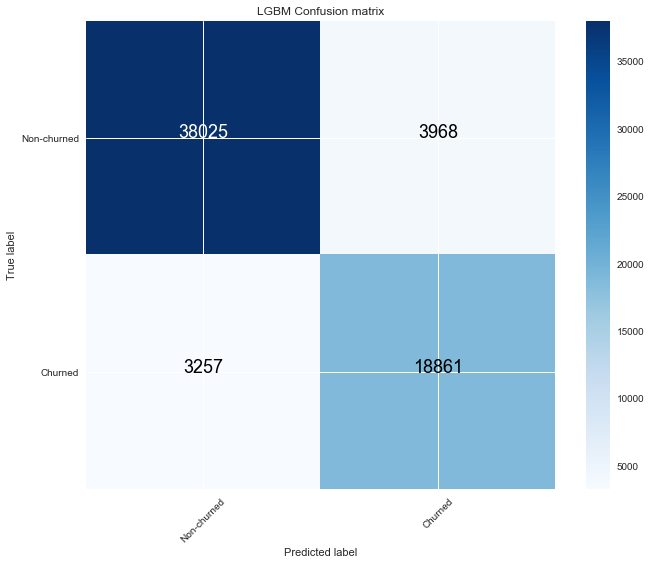

In [100]:
# Воспользуемся функцией построения матрицы ошибок из документации sklearn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 18}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_valid, lgbm.predict(X_valid))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='LGBM Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[38095  3898]
 [ 3242 18876]]


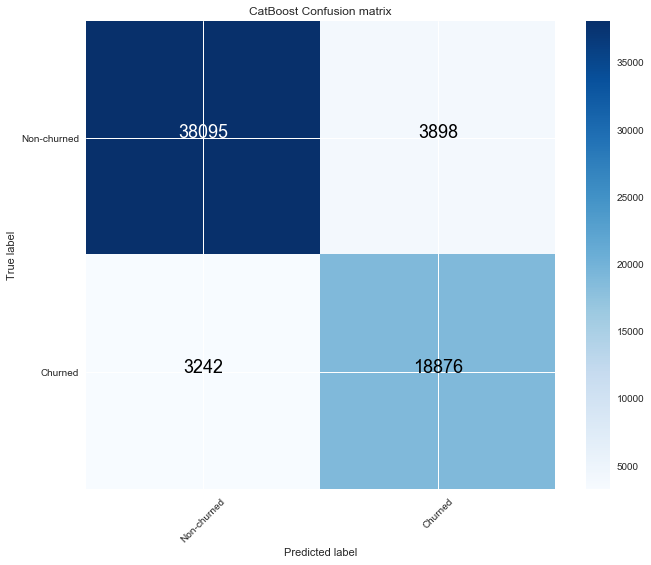

In [101]:
font = {'size' : 18}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_valid, model.predict(X_valid))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='CatBoost Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

## СДЕЛАЕМ ПРОГНОЗ НА НОЯБРЬ 2018

In [131]:
# загрузим данные по сессиям за 4 мес. (июль-август-сентябрь-октябрь 2018)

sessions = pd.read_csv('../dmitriilin/Downloads/sessions_july_october_2018.csv')

In [133]:
df_main_november_predict = sessions.groupby('DeviceID')[['SessionStartTimestamp']]\
    .count().reset_index().sort_values(by='SessionStartTimestamp', ascending=False)

df_main_november_predict['SessionStartDate'] = [sorted(list(set(sessions['SessionStartDate'].loc[sessions['DeviceID'] == x['DeviceID']])))  
    for _, x in df_main_november_predict.iterrows()]

df_main_november_predict['sessions_avgdaylag'] = df_main_november_predict.apply(lambda x: func(x['SessionStartDate']), axis=1)

tempSer = df_main_november_predict[df_main_november_predict['sessions_avgdaylag'].isnull()]['SessionStartDate'].apply(
     lambda x: round((int(round((reportDate - datetime.strptime(x[0], fmt)).total_seconds() / 60))) / 1440))

df_main_november_predict['sessions_avgdaylag'] = df_main_november_predict['sessions_avgdaylag'].fillna(tempSer)

temp = sessions.groupby('DeviceID')[['SessionStartDate']].max().reset_index()
temp['sessions_daysSinceLastSession'] = temp['SessionStartDate'].apply(
    lambda x: round((int(round((reportDate - datetime.strptime(x, fmt)).total_seconds() / 60))) / 1440))
df_main_november_predict = df_main_november_predict.join(temp.drop(['SessionStartDate'], axis=1).set_index('DeviceID'), on='DeviceID')

df_main_november_predict['sessions_totaldaysactive'] = df_main_november_predict['SessionStartDate'].apply(lambda x: len(x))

df_main_november_predict = df_main_november_predict.drop(['SessionStartDate'], axis=1).rename(index=str, columns={
    "SessionStartTimestamp": "sessions_totalnumber"
})

In [134]:
payments = pd.read_csv('../dmitriilin/Downloads/payments_july_october_2018.csv')

In [137]:
f = {
    'operationAmount':['count','sum', 'median', 'min', 'max'], #количество, сумма, медиана, минимум и максимум
    'sender': ['nunique'], #кол-во уникальных источников платежей
    'recipient': ['nunique'], #кол-во получателей платежей
    'operationMethod': ['nunique'] #кол-во способов платежей
}

# расчитаем агрегаты по каждому DeviceID

payments_agg = payments.groupby(['DeviceID']).agg(f)
payments_agg.columns = payments_agg.columns.map('_'.join)
payments_agg = payments_agg.reset_index().rename(columns={
    'operationAmount_count': 'payments_operationAmount_count',
    'operationAmount_sum': 'payments_operationAmount_sum',
    'operationAmount_median': 'payments_operationAmount_median',
    'operationAmount_min': 'payments_operationAmount_min',
    'operationAmount_max': 'payments_operationAmount_max',
    'sender_nunique': 'payments_sender_nunique',
    'recipient_nunique': 'payments_recipient_nunique',
    'operationMethod_nunique': 'payments_operationMethod_nunique'
})


payments_agg['payments_date'] = [sorted(list(set(payments['EventDate'].loc[payments['DeviceID'] == x['DeviceID']])))  
    for _, x in payments_agg.iterrows()]
payments_agg['payments_avgdaylag'] = payments_agg.apply(lambda x: func(x['payments_date']), axis=1)
payments_agg['payments_daysactive'] = payments_agg['payments_date'].apply(lambda x: len(x))

payments_agg = payments_agg.drop(['payments_date'], axis=1)
df_main_november_predict = df_main_november_predict.join(payments_agg.set_index('DeviceID'), on='DeviceID')
temp = payments.groupby('DeviceID')[['EventDate']].max().reset_index()
temp['payments_daysSinceLastPayment'] = temp['EventDate'].apply(
    lambda x: round((int(round((reportDate - datetime.strptime(x, fmt)).total_seconds() / 60))) / 1440))
df_main_november_predict = df_main_november_predict.join(temp.drop(['EventDate'], axis=1).set_index('DeviceID'), on='DeviceID')

fillna0 = [
    'payments_operationAmount_count',
    'payments_operationAmount_sum',
    'payments_operationAmount_median',
    'payments_operationAmount_min',
    'payments_operationAmount_max',
    'payments_sender_nunique',
    'payments_recipient_nunique',
    'payments_operationMethod_nunique',
    'payments_daysactive'
]

fillna110 = ['payments_avgdaylag', 'payments_daysSinceLastPayment']

for i in fillna0:
    df_main_november_predict[i].fillna(0, inplace=True)

for i in fillna110:
    df_main_november_predict[i].fillna(110, inplace=True)

In [138]:
fundTransfers = pd.read_csv('../dmitriilin/Downloads/transfers_july_october_2018.csv', sep=',')

In [139]:
f = {
    'operationAmount':['count','sum', 'median', 'min', 'max'], #количество и сумма операций
    'operationFee': ['sum'], #сумма комиссий
    'sender': ['nunique'], #кол-во источников перевода
    'recipient': ['nunique'], #кол-во получателей перевода
    'operationMethod': ['nunique'], #кол-во способов перевода
    'senderCurrency': ['nunique'], #кол-во валют источника перевода
    'recipientCurrency': ['nunique'] #кол-во валют получателя перевода
}

fundTransfers_agg = fundTransfers.groupby(['DeviceID']).agg(f)
fundTransfers_agg.columns = fundTransfers_agg.columns.map('_'.join)
fundTransfers_agg = fundTransfers_agg.reset_index().rename(columns={
    'operationAmount_count': 'transfers_operationAmount_count',
    'operationAmount_sum': 'transfers_operationAmount_sum',
    'operationAmount_median': 'transfers_operationAmount_median',
    'operationAmount_min': 'transfers_operationAmount_min',
    'operationAmount_max': 'transfers_operationAmount_max',
    'operationFee_sum': 'transfers_operationFee_sum',
    'sender_nunique': 'transfers_sender_nunique',
    'recipient_nunique': 'transfers_recipient_nunique',
    'operationMethod_nunique': 'transfers_operationMethod_nunique',
    'senderCurrency_nunique': 'transfers_senderCurrency_nunique',
    'recipientCurrency_nunique': 'transfers_recipientCurrency_nunique'
})

fundTransfers_agg['transfers_date'] = [sorted(list(set(fundTransfers['EventDate'].loc[fundTransfers['DeviceID'] == x['DeviceID']])))  
    for _, x in fundTransfers_agg.iterrows()]

fundTransfers_agg['transfers_avgdaylag'] = fundTransfers_agg.apply(lambda x: func(x['transfers_date']), axis=1)
fundTransfers_agg['transfers_daysactive'] = fundTransfers_agg['transfers_date'].apply(lambda x: len(x))

fundTransfers_agg = fundTransfers_agg.drop(['transfers_date'], axis=1)

df_main_november_predict = df_main_november_predict.join(fundTransfers_agg.set_index('DeviceID'), on='DeviceID')

temp = fundTransfers.groupby('DeviceID')[['EventDate']].max().reset_index()
temp['transfers_daysSinceLastTransfer'] = temp['EventDate'].apply(
    lambda x: round((int(round((reportDate - datetime.strptime(x, fmt)).total_seconds() / 60))) / 1440))
df_main_november_predict = df_main_november_predict.join(temp.drop(['EventDate'], axis=1).set_index('DeviceID'), on='DeviceID')

fillna0 = [
    'transfers_operationAmount_count',
    'transfers_operationAmount_sum',
    'transfers_operationAmount_median',
    'transfers_operationAmount_min',
    'transfers_operationAmount_max',
    'transfers_operationFee_sum',
    'transfers_sender_nunique',
    'transfers_recipient_nunique',
    'transfers_operationMethod_nunique',
    'transfers_senderCurrency_nunique',
    'transfers_recipientCurrency_nunique',
]

fillna110 = ['transfers_avgdaylag', 'transfers_daysactive', 'transfers_daysSinceLastTransfer']

for i in fillna0:
    df_main_november_predict[i].fillna(0, inplace=True)

for i in fillna110:
    df_main_november_predict[i].fillna(110, inplace=True)

In [140]:
# общее количество сессий за 3 месяца меньше 2

df_main_november_predict['sessions_totalnumber_less_2'] = df_main_november_predict['sessions_totalnumber'].apply(lambda x: 1 if x < 2 else 0)

# общее количество сессий за 3 месяца меньше 6

df_main_november_predict['sessions_totalnumber_less_6'] = df_main_november_predict['sessions_totalnumber'].apply(lambda x: 1 if x < 6 else 0)

# общее количество активных дней за 1 месяц меньше 2

df_main_november_predict['sessions_totaldaysactive_less_2'] = df_main_november_predict['sessions_totaldaysactive'].apply(lambda x: 1 if x < 2 else 0)

df_main_november_predict['sessions_avgdaylag_greater_20'] = df_main_november_predict['sessions_avgdaylag'].apply(lambda x: 1 if x > 20.5 else 0)
df_main_november_predict['sessions_avgdaylag_greater_10'] = df_main_november_predict['sessions_avgdaylag'].apply(lambda x: 1 if x > 10 else 0)
df_main_november_predict['sessions_avgdaylag_greater_15'] = df_main_november_predict['sessions_avgdaylag'].apply(lambda x: 1 if x > 15 else 0)
df_main_november_predict['sessions_totaldaysactive_equalsless_2'] = df_main_november_predict['sessions_totaldaysactive'].apply(lambda x: 1 if x <= 2 else 0)
df_main_november_predict['sessions_daysSinceLastSession_equalsgreater_19'] = df_main_november_predict['sessions_daysSinceLastSession'].apply(lambda x: 1 if x >= 19 else 0)
df_main_november_predict['sessions_totalnumber_equalsless_5'] = df_main_november_predict['sessions_totalnumber'].apply(lambda x: 1 if x <= 5 else 0)

df_main_november_predict['sessions_isPassive'] = df_main_november_predict.apply(lambda row: label_race (row),axis=1)

df_main_november_predict['payments_isPassive'] = df_main_november_predict['payments_operationAmount_count'].apply(lambda x: 1 if x == 0 else 0)
df_main_november_predict['transfers_isPassive'] = df_main_november_predict['transfers_operationAmount_count'].apply(lambda x: 1 if x == 0 else 0)

### Предсказываем отток

In [165]:
df_main_november_predict['will_churn'] = lgbm.predict(df_main_november_predict)

In [166]:
df_main_november_predict[['DeviceID', 'will_churn']]['will_churn'].value_counts()

0    212601
1     33888
Name: will_churn, dtype: int64

In [168]:
df_main_november_predict['will_churn'].value_counts(normalize=True)

0   0.86
1   0.14
Name: will_churn, dtype: float64

In [171]:
df_main_november_predict.columns

Index(['DeviceID', 'sessions_totalnumber', 'sessions_avgdaylag',
       'sessions_daysSinceLastSession', 'sessions_totaldaysactive',
       'payments_operationAmount_count', 'payments_operationAmount_sum',
       'payments_operationAmount_median', 'payments_operationAmount_min',
       'payments_operationAmount_max', 'payments_sender_nunique',
       'payments_recipient_nunique', 'payments_operationMethod_nunique',
       'payments_avgdaylag', 'payments_daysactive',
       'payments_daysSinceLastPayment', 'transfers_operationAmount_count',
       'transfers_operationAmount_sum', 'transfers_operationAmount_median',
       'transfers_operationAmount_min', 'transfers_operationAmount_max',
       'transfers_operationFee_sum', 'transfers_sender_nunique',
       'transfers_recipient_nunique', 'transfers_operationMethod_nunique',
       'transfers_senderCurrency_nunique',
       'transfers_recipientCurrency_nunique', 'transfers_avgdaylag',
       'transfers_daysactive', 'transfers_daysSinceLa

In [172]:
df_main_november_predict[df_main_november_predict['will_churn'] == 1]['sessions_daysSinceLastSession'].describe()

count   33888.00
mean       33.29
std        17.92
min       -48.00
25%        20.00
50%        34.00
75%        48.00
max        62.00
Name: sessions_daysSinceLastSession, dtype: float64

In [95]:
# crmIds = 
events[events['DeviceID'].isin(df_main_september_predict[df_main_september_predict['will_churn'] == 1]['DeviceID'])]

In [174]:
df_main_november_predict.to_csv('../dmitriilin/Desktop/df_main_november_predict.csv')

In [118]:
crmIds['Dev']

7601

In [102]:
crmIds_will_churn = crmIds.groupby('DeviceID')[['crmId']].min().reset_index()

In [123]:
crmIds_will_churn[~crmIds_will_churn['crmId'].isnull()].reset_index().drop('index', axis=1)\
    .to_csv('../dmitriilin/Desktop/predicted_as_churn_september_2018.csv')

### Сохраняем модель

```python
with open(FILENAME, 'wb') as f:
    pickle.dump(model, f)
    
    
with open(FILENAME, 'rb') as f:
    model = pickle.load(f)
```

In [163]:
import pickle as pkl

with open('lgbm_model.pkl', 'wb') as f:
    pkl.dump(lgbm, f)

In [164]:
with open('lgbm_model.pkl', 'rb') as f:
    model = pkl.load(f)

In [130]:
model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_bin=1024, max_depth=-1, min_child_samples=5,
        min_child_weight=1, min_split_gain=0.5, n_estimators=100,
        n_jobs=-1, num_iterations=200, num_leaves=34, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=1, silent=True, subsample=1,
        subsample_for_bin=200, subsample_freq=1)